In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import boxcox
from scipy.special import inv_boxcox


from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor


In [3]:
df = pd.read_csv('air_passenger.csv',sep=';')

df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')

# add exog
df['exog1'] = df['volume'] ** .5
df['exog2'] = df['volume'] + np.random.random(len(df.index))*10
df['exog3'] = 'low'
df.loc[df['volume']>df['volume'].mean(),'exog3'] = 'high'

print(df.shape)
df.head(2)

(144, 5)


,date,volume,exog1,exog2,exog3
0,1949-01-01,112,10.583005,119.964658,low
1,1949-02-01,118,10.862780,125.475612,low


<AxesSubplot:xlabel='date'>

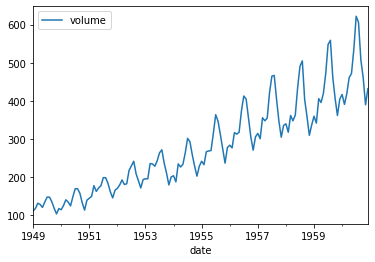

In [4]:
df.plot('date','volume')

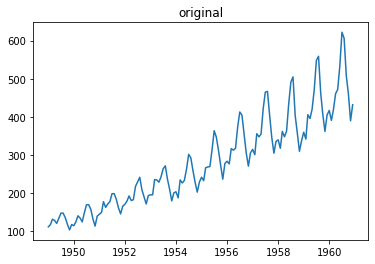

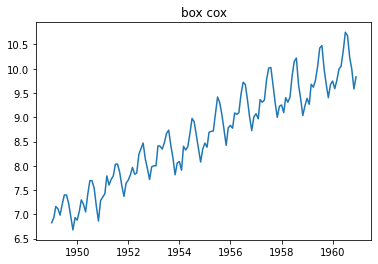

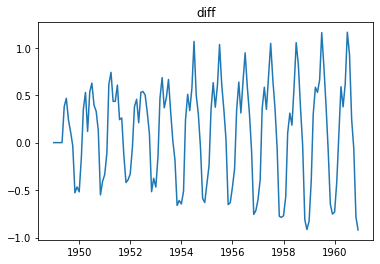

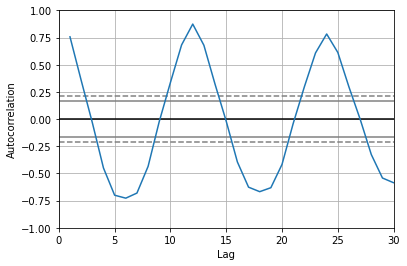

In [5]:
# stationarity
lag = 5

y = df['volume']
y.index = df['date']
plt.plot(y)
plt.title('original')
plt.show()

temp, lmbda = boxcox(y)
temp = pd.Series(temp,index=y.index)
plt.plot(temp)
plt.title('box cox')
plt.show()

y_new = (temp - temp.shift(lag)).fillna(0)

plt.plot(y_new)
plt.title('diff')
plt.show()

# seasonality from auto_corr
pd.plotting.autocorrelation_plot(y_new)
plt.xlim(0,30)
plt.show()

In [9]:
y

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: volume, Length: 144, dtype: int64

In [10]:
y.shift(3)

date
1949-01-01      NaN
1949-02-01      NaN
1949-03-01      NaN
1949-04-01    112.0
1949-05-01    118.0
              ...  
1960-08-01    472.0
1960-09-01    535.0
1960-10-01    622.0
1960-11-01    606.0
1960-12-01    508.0
Name: volume, Length: 144, dtype: float64

In [8]:
y - y.shift(3)

date
1949-01-01      NaN
1949-02-01      NaN
1949-03-01      NaN
1949-04-01     17.0
1949-05-01      3.0
              ...  
1960-08-01    134.0
1960-09-01    -27.0
1960-10-01   -161.0
1960-11-01   -216.0
1960-12-01    -76.0
Name: volume, Length: 144, dtype: float64

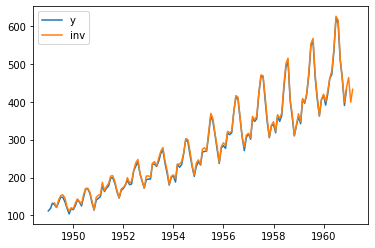

In [26]:
# diff and inverse diff
horizon = 3

y = df['volume']
y.index = df['date']
y = y.reindex(pd.date_range(start=df['date'].min(),periods=len(df.index)+horizon,freq=df['date'].dt.freq))

temp = (y - y.shift(horizon)).fillna(0)

r = temp + np.random.rand(len(temp))*10

#temp[0] = y[0]
#y_inv = temp.cumsum()
y_inv = r + y.shift(horizon)

plt.plot(y,label='y')
plt.plot(y_inv,label='inv')
plt.legend()
plt.show()

In [23]:
y.shift(horizon)

1949-01-01      NaN
1949-02-01      NaN
1949-03-01      NaN
1949-04-01    112.0
1949-05-01    118.0
              ...  
1960-11-01    606.0
1960-12-01    508.0
1961-01-01    461.0
1961-02-01    390.0
1961-03-01    432.0
Freq: MS, Name: volume, Length: 147, dtype: float64

In [20]:
y - y.shift(horizon)

1949-01-01      NaN
1949-02-01      NaN
1949-03-01      NaN
1949-04-01     17.0
1949-05-01      3.0
              ...  
1960-11-01   -216.0
1960-12-01    -76.0
1961-01-01      NaN
1961-02-01      NaN
1961-03-01      NaN
Freq: MS, Name: volume, Length: 147, dtype: float64

In [ ]:
y_pred = y_shift

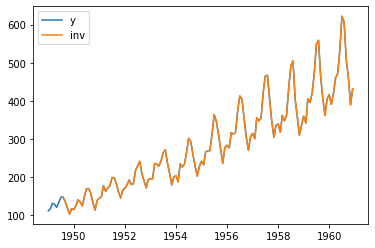

In [6]:
# transform and diff, and untransform and undiff

y = df['volume']
y.index = df['date']

temp, lmbda = boxcox(y)
y_shift = pd.Series(temp,index=y.index)
y_new = (y_shift - y_shift.shift(lag))#.fillna(0)

# untransform
temp = y_new + y_shift.shift(lag)
y_inv = inv_boxcox(temp,lmbda)

plt.plot(y,label='y')
plt.plot(y_inv,label='inv')
plt.legend()
plt.show()

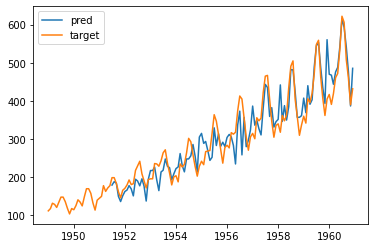

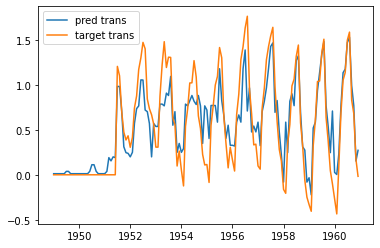

In [7]:
# transform, diff and predict, untransform and undiff
horizon = 30
lag = horizon
y = df['volume']
y.index = df['date']

X = df[['volume']].values.reshape(-1,1)

# transform
temp, lmbda = boxcox(y)
temp = pd.Series(temp,index=y.index)
y_shift = temp
y_new = (temp - temp.shift(lag)).fillna(0)

# regress on new
clf = GradientBoostingRegressor()
clf.fit(X,y_new)
y_pred_new = pd.Series(clf.predict(X),index=y_new.index)

# untransform
temp = y_pred_new + y_shift.shift(lag) 
y_pred = inv_boxcox(temp,lmbda)

plt.plot(y_pred,label='pred')
plt.plot(y,label='target')
plt.legend()
plt.show()


plt.plot(y_pred_new,label='pred trans')
plt.plot(y_new,label='target trans')
plt.legend()
plt.show()

<ipython-input-27-e8d38b97c715>:27: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X_new['week_of_year'] = y.index.weekofyear


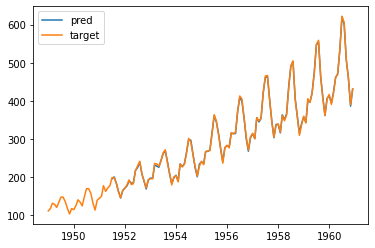

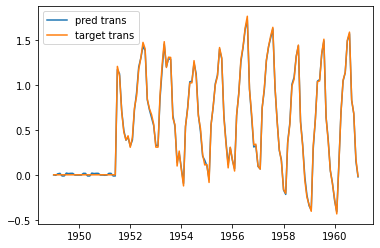

In [27]:
# transform, featurize, predict, untransform

horizon = 30
lag = horizon
y = df['volume']
y.index = df['date']

input_cols = ['exog1','exog2']
X = df[input_cols]

# transform
temp, lmbda = boxcox(y)
temp = pd.Series(temp,index=y.index)
y_shift = temp
y_new = (temp - temp.shift(lag)).fillna(0)

# featurize
X_new = X.copy()
feat_cols = []

X_new['day_of_week'] = y.index.day_of_week
feat_cols.append('day_of_week')
X_new['day_of_month'] = y.index.day
feat_cols.append('day_of_month')
X_new['day_of_year'] = y.index.day_of_year
feat_cols.append('day_of_year')
X_new['week_of_year'] = y.index.weekofyear
feat_cols.append('week_of_year')
X_new['month_of_year'] = y.index.month
feat_cols.append('month_of_year')

for col in input_cols:
    for x in range(horizon,horizon+lag):
        X_new[col+'_'+str(x)] = X[col].shift(x,fill_value=0)
        feat_cols.append(col+'_'+str(x))

# regress on new
clf = GradientBoostingRegressor()
clf.fit(X_new[feat_cols],y_new)
y_pred_new = pd.Series(clf.predict(X_new[feat_cols]),index=y_new.index)

# untransform
temp = y_pred_new + y_shift.shift(lag) 
y_pred = inv_boxcox(temp,lmbda)

plt.plot(y_pred,label='pred')
plt.plot(y,label='target')
plt.legend()
plt.show()


plt.plot(y_pred_new,label='pred trans')
plt.plot(y_new,label='target trans')
plt.legend()
plt.show()



In [ ]:
# transform, featurize, forecast, untransform

horizon = 30
lag = horizon
y = df['volume']
y.index = df['date']

input_cols = ['exog1','exog2']
X = df[input_cols]

# transform
temp, lmbda = boxcox(y)
temp = pd.Series(temp,index=y.index)
y_shift = temp
y_new = (temp - temp.shift(lag)).fillna(0)

# featurize
X_new = X.copy()
feat_cols = []

X_new['day_of_week'] = y.index.day_of_week
feat_cols.append('day_of_week')
X_new['day_of_month'] = y.index.day
feat_cols.append('day_of_month')
X_new['day_of_year'] = y.index.day_of_year
feat_cols.append('day_of_year')
X_new['week_of_year'] = y.index.weekofyear
feat_cols.append('week_of_year')
X_new['month_of_year'] = y.index.month
feat_cols.append('month_of_year')

for col in input_cols:
    for x in range(horizon,horizon+lag):
        X_new[col+'_'+str(x)] = X[col].shift(x,fill_value=0)
        feat_cols.append(col+'_'+str(x))

# regress on new
clf = GradientBoostingRegressor()
clf.fit(X_new[feat_cols],y_new)
y_pred_new = pd.Series(clf.predict(X_new[feat_cols]),index=y_new.index)

# untransform
temp = y_pred_new + y_shift.shift(lag) 
y_pred = inv_boxcox(temp,lmbda)

plt.plot(y_pred,label='pred')
plt.plot(y,label='target')
plt.legend()
plt.show()


plt.plot(y_pred_new,label='pred trans')
plt.plot(y_new,label='target trans')
plt.legend()
plt.show()

